# AUC metric, or any other "distance" metric, might be deceitful.
*A demonstration*

In [1]:
import hypothesis as h
import torch
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import os

from torch.distributions.normal import Normal
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
!date

Tue 14 Sep 2021 04:23:17 PM CEST


In [3]:
# Activate the `hypothesis` plotting style
h.plot.activate()

## Setting

Notebook arguments. The following cell also contains the `parameters` tag, such that it can be parameterized with [Papermill](https://papermill.readthedocs.io/en/latest/).

In [4]:
root = os.path.abspath('')
outputdir = root + "/output"

Create and clean data directories. Initialize some variables based on the Notebook's parameterization.

In [5]:
plotdir = outputdir + "/plots"
!rm -r $plotdir
!mkdir -p $plotdir

## Utilities

In [6]:
def estimate_auc(samples_a, samples_b):
    assert len(samples_a) == len(samples_b)
    ones = np.ones((len(samples_a), 1))
    zeros = np.zeros((len(samples_b), 1))
    X = np.hstack([samples_a, samples_b]).reshape(-1, 1)
    y = np.vstack([ones, zeros]).reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    clf = MLPClassifier(hidden_layer_sizes=(128, 128))
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)

    return auc(fpr, tpr)

## Scenario

In [7]:
num_samples = 100000

In [8]:
p = Normal(0, 1)
q_overconfident = Normal(0, 0.5)
q_conservative = Normal(0, 2.0)

In [9]:
samples_p = p.sample((num_samples,)).numpy()
samples_q_o = q_overconfident.sample((num_samples,)).numpy()
samples_q_c = q_conservative.sample((num_samples,)).numpy()

In [10]:
# Compute AUC score for overconfident "approximation"
auc_o = estimate_auc(samples_p, samples_q_o)
# Compute AUC score for conservative "approximation"
auc_c = estimate_auc(samples_p, samples_q_c)

In [11]:
h.plot.activate()

2021-09-14 16:24:36 orion matplotlib.font_manager[9066] WARNING findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


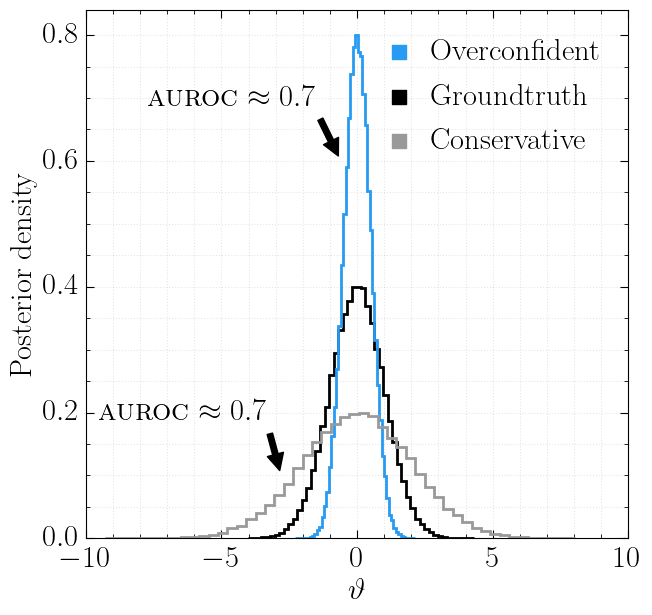

In [12]:
f = plt.figure(figsize=(7, 7))
plt.hist(samples_p, histtype="step", density=True, lw=2, bins=50)
plt.hist(samples_q_o, histtype="step", density=True, lw=2, bins=50)
plt.hist(samples_q_c, histtype="step", density=True, lw=2, bins=50)
plt.ylabel("Posterior density")
plt.xlabel(r"$\vartheta$")
ylim = plt.gca().get_ylim()

a_o = "{:.1f}".format(auc_o)
a_c = "{:.1f}".format(auc_c)
plt.annotate(r"$\textsc{auroc}\approx " + a_o + r"$", xy=(-0.6, 0.6), xytext=(-7.7, 0.7), va="center", arrowprops=dict(facecolor='black', edgecolor='black', shrink=0.1),)
plt.annotate(r"$\textsc{auroc}\approx " + a_c + r"$", xy=(-2.8, 0.1), xytext=(-9.5, 0.2), va="center", arrowprops=dict(facecolor='black', edgecolor='black', shrink=0.1),)


plt.scatter([-1000], [-1000], label="Overconfident", color="C1", marker='s', s=100)
plt.scatter([-1000], [-1000], label="Groundtruth", color="C0", marker='s', s=100)
plt.scatter([-1000], [-1000], label="Conservative", color="C2", marker='s', s=100)
plt.legend(handletextpad=0.05)
plt.gca().set_xlim([-10, 10])
plt.gca().set_ylim(ylim)

plt.savefig(plotdir + "/auc-deceitful.pdf")
plt.show()